In [1]:
"""
These Python functions are used to calculate the growth-optimal leverage for a strategy based on its
backtest performance. Each trade's profit or loss is treated as one sample, from an underlying probability
distribution which is generating the PnLs. This function optimizes the amount of leverage one would use when
betting on this distribution, assuming that the strategy will have the same performance in the near future.

Example:

# Load some data from yahoo
import matplotlib.finance as fin
import datetime
import pylab

start = datetime.datetime(2006,1,1)
end = datetime.datetime(2007,1,1)

bars = fin.quotes_historical_yahoo('SPY', start, end)
import numpy as np
close = np.array([bar[4] for bar in bars])
close = close[range(0, len(close), 5)] # Convert to weekly resolution
returns = np.diff(close)/close[:-1]

# Empirical Kelly
kelly(returns)

# Continuous/Gaussian Analytic Kelly
np.mean(returns)/np.var(returns)

pylab.hist(returns)
pylab.show()
# Good: Heavy left tail caused empirical Kelly to be less than continuous/Gaussian Kelly.
# Recall that tail risk arises from platykurtotic returns, increasing the probability of extreme events.
# Kurtosis of a Gaussian distribution is 3.
"""

"\nThese Python functions are used to calculate the growth-optimal leverage for a strategy based on its\nbacktest performance. Each trade's profit or loss is treated as one sample, from an underlying probability\ndistribution which is generating the PnLs. This function optimizes the amount of leverage one would use when\nbetting on this distribution, assuming that the strategy will have the smae performance in the near future.\n\nExample:\n\n# Load some data from yahoo\nimport matplotlib.finance as fin\nimport datetime\nimport pylab\n\nstart = datetime.datetime(2006,1,1)\nend = datetime.datetime(2007,1,1)\n\nbars = fin.quotes_historical_yahoo('SPY', start, end)\nimport numpy as np\nclose = np.array([bar[4] for bar in bars])\nclose = close[range(0, len(close), 5)] # Convert to weekly resolution\nreturns = np.diff(close)/close[:-1]\n\n# Empirical Kelly\nkelly(returns)\n\n# Continuous/Gaussian Analytic Kelly\nnp.mean(returns)/np.var(returns)\n\npylab.hist(returns)\npylab.show()\n# Good: H

In [9]:
from __future__ import print_function
import datetime
import numpy as np
import pylab
import pandas_datareader.data as web
import scipy.optimize


In [37]:
def kelly(hist_returns, binned_optimization=False, num_bins=100, stop_loss=-np.inf):
    """
    Compute the optimal multiplier to leverage historical returns.
    
    Parameters
    ----------
    hist_returns : ndarray
        Arithmetic 1-pd returns.
    binned_optimization : bool
        See empirical distribution; fewer bins improves runtime.
    num_bins : int
        See empirical distribution; fewer bins improves runtime.
    stop_loss : double
        Experimental; simulate the effect of a stop loss at stop_loss
        percent return.
        
    Returns
    -------
    f : float
        The optimal leverage factor.
    """
    
    if stop_loss > -np.inf:
        stopped_out = hist_returns < stop_loss
        hist_returns[stopped_out] = stop_loss
        
    probabilities, returns = empirical_distribution(hist_returns, binned_optimization, num_bins) # def below...
    print(probabilities, returns)
    
    # f is the optimal leverage factor
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html#scipy.optimize.fmin_cg
    expected_log_return = lambda f: expectation(probabilities, np.log(1+f*returns)) 
    objective = lambda f: -expected_log_return(f)
    derivative = lambda f: -expectation(probabilities, returns/(1.+f*returns))
    
    return scipy.optimize.fmin_cg(f=objective, x0=1.0, fprime=derivative, disp=1, full_output=1,
                                  maxiter=5000, callback=callback)


In [38]:
def empirical_distribution(hist_returns, binned_optimization=True, num_bins=100):
    """
    Aggreggate observations and generate an empirical probability distribution of the historical returns.
    
    Parameters
    ----------
    hist_returns : ndarray
        Observations; assume uniform probability, i.e.: point masses.
    binned_optimization : bool
        Determines whether to aggregate the point masses in order to speed computations using the distribution.
    num_bins : int
        The number of bins for the histogram. Fewer bins improves runtime, but hides granular details
        due to lower data resolution.
        
    Returns
    -------
    probabilities : ndarray
        Returns the probabilities of respective events.
    returns : ndarray
        Returns the events/aggregated observations.
    """
    if binned_optimization:
        frequencies, return_bins = np.histogram(hist_returns, bins=num_bins)
        probabilities = np.double(frequencies)/len(hist_returns)
        returns = (return_bins[:-1] + return_bins[1:]) / 2
    else:
        # Uniform point masses at each return observation
        probabilities = np.double(np.ones_like(hist_returns)) / len(hist_returns)
        returns = hist_returns
    
    return probabilities, returns
    

In [39]:
def expectation(probabilites, returns):
    """
    Compute the expected value of a discrete set of events given their probabilites.
    """
    return sum(probabilites * returns)

In [40]:
def callback(call):
    print(call)

[ 0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.00

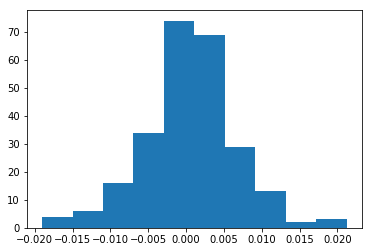

In [41]:
# Load some data from yahoo


start = datetime.datetime(2006,1,1)
end = datetime.datetime(2007,1,1)

spy = web.DataReader("SPY", "yahoo", start, end)
close = spy["Adj Close"]
#close = close[0:len(close):5] # Convert to weekly resolution
returns = np.diff(close)/close[:-1]

# Empirical Kelly
kelly(returns)

# Continuous/Gaussian Analytic Kelly
np.mean(returns)/np.var(returns)

pylab.hist(returns)
pylab.show()
# Good: Heavy left tail caused empirical Kelly to be less than continuous/Gaussian Kelly.
# Recall that tail risk arises from platykurtotic returns, increasing the probability of extreme events.
# Kurtosis of a Gaussian distribution is 3.